In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import os
import pickle
import matplotlib.pyplot as plt

import requests
import numpy as np
import gzip
import shutil
import datasets
from nltk.translate.bleu_score import sentence_bleu

# Notebook Paramters

In [ ]:
src = 'en'
tgt = 'fr'
SEED = 47

# Get Data

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("opus_books", "en-fr")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

In [ ]:
def extract_languages(examples):
    inputs = [ex["en"] for ex in examples["translation"]]
    targets = [ex["fr"] for ex in examples["translation"]]
    return {"inputs": inputs, "targets": targets}

raw_datasets = raw_datasets.map(extract_languages, batched=True, remove_columns=["id", "translation"])

Map:   0%|          | 0/127085 [00:00<?, ? examples/s]

In [ ]:
train_test_split = raw_datasets["train"].train_test_split(test_size=0.1, seed=47)


src_train_sentences = train_test_split['train'][0:]['inputs']
tgt_train_sentences = train_test_split['train'][0:]['targets']


src_lens = [len(sent) for sent in src_train_sentences]
tgt_lens = [len(sent) for sent in tgt_train_sentences]

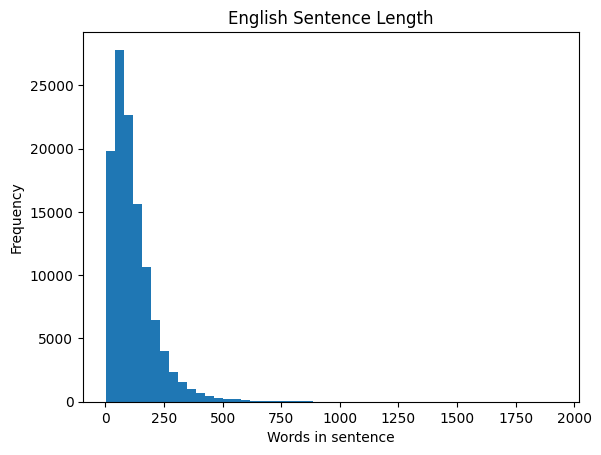

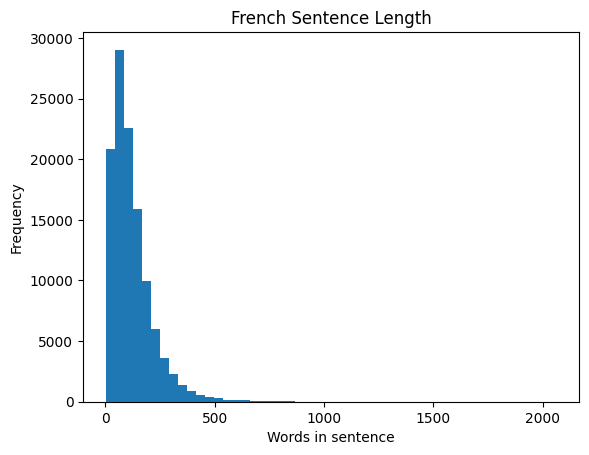

In [ ]:
plt.hist(src_lens, bins=50)
plt.title('English Sentence Length')
plt.xlabel('Words in sentence')
plt.ylabel('Frequency')
plt.show()

plt.hist(tgt_lens, bins=50)
plt.title('French Sentence Length')
plt.xlabel('Words in sentence')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# according to above distributions. 250 seems reasonable
max_sequence_length = 250

src_train_sentences = [sentence.rstrip('\n').lower().replace('"',"").replace('-',"") for sentence in src_train_sentences]
tgt_train_sentences = [sentence.rstrip('\n').lower().replace('-',"") for sentence in tgt_train_sentences]

src_train_sentences = [sentence[:max_sequence_length - 2] for sentence in src_train_sentences]
tgt_train_sentences = [sentence[:max_sequence_length - 2] for sentence in tgt_train_sentences]

# Subtract 2 to give room for the start and end tokens

In [ ]:
!pip install tokenizers==0.15.2

In [ ]:
from tokenizers import Tokenizer, models, pre_tokenizers, trainers
START_TOKEN = '<s>'
PADDING_TOKEN = '[PAD]'
END_TOKEN = '</s>'
UNK_TOKEN = "[UNK]"

SPECIAL_TOKENS = [UNK_TOKEN, START_TOKEN, END_TOKEN , PADDING_TOKEN]



def create_and_tokenizers(src_sentences, tgt_sentences):
  """"
  Creates tokenizers for source and target languages
  """
  # Source lang tokenizer
  src_tokenizer = Tokenizer(models.WordPiece(unk_token=UNK_TOKEN))
  src_tokenizer.add_special_tokens(SPECIAL_TOKENS)
  src_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
  trainer = trainers.WordPieceTrainer(vocab_size=32000, special_tokens=SPECIAL_TOKENS)
  src_tokenizer.train_from_iterator(src_sentences, trainer=trainer)


   # Target lang tokenizer
  tgt_tokenizer = Tokenizer(models.WordPiece(unk_token=UNK_TOKEN))
  tgt_tokenizer.add_special_tokens(SPECIAL_TOKENS)

  tgt_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

  trainer = trainers.WordPieceTrainer(vocab_size=32000, special_tokens= SPECIAL_TOKENS)
  tgt_tokenizer.train_from_iterator(tgt_sentences, trainer=trainer)

  return src_tokenizer, tgt_tokenizer


src_tokenizer, tgt_tokenizer = create_and_tokenizers(src_train_sentences, tgt_train_sentences)

In [ ]:
src_vocab_size = src_tokenizer.get_vocab_size()
tgt_vocab_size = tgt_tokenizer.get_vocab_size()

src_to_index = src_tokenizer.get_vocab()
tgt_to_index = tgt_tokenizer.get_vocab()

index_to_src = {v:k for k, v in src_to_index.items()}
index_to_tgt = {v:k for k, v in tgt_to_index.items()}

src_vocab_size, tgt_vocab_size

(32000, 32000)

In [ ]:
sentence = "<s> my name is jacob </s>"


encodings = src_tokenizer.encode(sentence)


In [ ]:
encodings.tokens

['<s>', 'my', 'name', 'is', 'jacob', '</s>']

In [ ]:
encodings.ids

[1, 288, 1079, 291, 8872, 2]

# Data Loader

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):

    def __init__(self, src_sentences, tgt_sentences):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, idx):
        return self.src_sentences[idx], self.tgt_sentences[idx]

train_dataset = TextDataset(src_train_sentences, tgt_train_sentences)

# Transformer Architecture

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
def batch_tokenize(batch, start_token, end_token, tokenizer):

  token_batch = tokenizer.encode_batch(batch)
  token_batch = [tokens.ids for tokens in token_batch]

  if start_token:
    token_batch = [[src_to_index[START_TOKEN]] + tokens for tokens in token_batch]

  if end_token:
    token_batch = [tokens + [src_to_index[END_TOKEN]] for tokens in token_batch]

  token_batch = [tokens + [src_to_index[PADDING_TOKEN]]*(max_sequence_length- len(tokens)) for tokens in token_batch]

  token_batch = [torch.Tensor(tokens) for tokens in token_batch]
  token_batch = torch.stack(token_batch).long()
  return token_batch.to(device)


In [ ]:
class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len,
        device,
    ):
        super(Transformer, self).__init__()
        self.src_word_embedding = nn.Embedding(src_vocab_size, embedding_size)
        self.src_position_embedding = nn.Embedding(max_len, embedding_size)
        self.trg_word_embedding = nn.Embedding(trg_vocab_size, embedding_size)
        self.trg_position_embedding = nn.Embedding(max_len, embedding_size)

        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
        )
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx

    def make_src_mask(self, src):
        src_mask = src.transpose(0, 1) == self.src_pad_idx

        # (N, src_len)
        return src_mask.to(self.device)

    def forward(self, src, trg):
        src_seq_length, N = src.shape
        trg_seq_length, N = trg.shape

        src_positions = (
            torch.arange(0, src_seq_length)
            .unsqueeze(1)
            .expand(src_seq_length, N)
            .to(self.device)
        )

        trg_positions = (
            torch.arange(0, trg_seq_length)
            .unsqueeze(1)
            .expand(trg_seq_length, N)
            .to(self.device)
        )

        embed_src = self.dropout(
            (self.src_word_embedding(src) + self.src_position_embedding(src_positions))
        )
        embed_trg = self.dropout(
            (self.trg_word_embedding(trg) + self.trg_position_embedding(trg_positions))
        )

        src_padding_mask = self.make_src_mask(src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(
            self.device
        )

        out = self.transformer(
            embed_src,
            embed_trg,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask,
        )
        out = self.fc_out(out)
        return out

# Trainning

In [ ]:
batch_size = 32 # how many independent sequences will we process in parallel?
d_model = 512 # number of embeddings
n_head = 8  # Self attention heads
n_layer = 2 # #encoder decoder layers or blocks
dropout = 0.1 # helps with over fitting
src_pad_idx = src_to_index[PADDING_TOKEN]

num_encoder_layers = 3
num_decoder_layers = 3
forward_expansion = 4

train_loader = DataLoader(train_dataset, batch_size)
train_iterator = iter(train_loader)

## Ignore Padding Tokens, loss function, and optmizer

In [ ]:
model = Transformer(
    d_model,
    src_vocab_size,
    tgt_vocab_size,
    src_pad_idx,
    n_head,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_sequence_length,
    device,
).to(device)

learning_rate = 3e-4

criterion = nn.CrossEntropyLoss(ignore_index=tgt_to_index[PADDING_TOKEN])

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
# Testing

x,y = next(train_iterator)

input = batch_tokenize(x, False, False, src_tokenizer)
target = batch_tokenize(x, True, True, tgt_tokenizer)

logits = model(input, target)

# Translation

In [ ]:
def join_words_with_hashes(text):
    words = text.split()
    result = [words[0]]  # Initialize result list with the first word
    for word in words[1:]:
        if word.startswith("##"):
            result[-1] += word[2:]  # Join the word starting with "##" to the previous word
        else:
            result.append(word)  # Add non-"##" word to result list
    return ' '.join(result)

In [ ]:
sentence = "what is your name"
tokens = src_tokenizer.encode(sentence)
max_length = max_sequence_length

def translate_sentence(model , sentence, max_length):

  tokens = src_tokenizer.encode(sentence).ids
  tokens =  tokens + [src_to_index[PADDING_TOKEN]] * (max_length - len(tokens))
  sentence_tensor = torch.LongTensor(tokens).unsqueeze(1).to(device)

  outputs = [tgt_to_index[START_TOKEN]]


  for i in range(max_length):

      trg_tensor = torch.LongTensor(outputs).unsqueeze(1).to(device)

      with torch.no_grad():
          output = model(sentence_tensor, trg_tensor)

      best_guess = output.argmax(2)[-1, :].item()
      outputs.append(best_guess)

      if best_guess == END_TOKEN:
          break

  translated_sentence = join_words_with_hashes(tgt_tokenizer.decode(outputs))

  return translated_sentence

In [ ]:
translate_sentence(model, sentence, max_sequence_length)








'avort papouas enable fondaient projetées fondaient fondaient projetées avort farragut éternellement projetées enable boc éternellement projetées fondaient enable hide avort projetées désiraient terminé apercevions fondaient fondaient enable riant abî avort avort mêlé préféraient enableation europé avort enable avort papouascy avort avort avort superflu fondaient apercevionsraijeotes avort avort enable éternellement éternellement projetées désiraient avort avort papouas enableaissa désiraient clarté avort fondaient fondaient fondaient fondaient hide fondaient projetées pall projetées désiraient enable avort avort endomm pierreux papouas enable papouas apercevions rendre fondaient fondaient rouvrir avort enable avort papouas enable avort avort enable enable wives faisait avort entraînéeraije avort avort enable avort avort enablerat enable fondaient fondaient fondaient éternellement fondaient goûté goûté papouas avort imaginationraije avort enable clarté avort papouas enable avort papoua

## Loop

In [ ]:
torch.save(obj=transformer.state_dict(), f="transformer 512_8_2_KDE4_15 5 epochs word levle.pth")

# Model Generation